# Part- 1 - Exploratory data analysis

#### Objective - aggregate login into 15 minutes interval and observe and underlying pattern among user behaviors on timing on using the service.

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

C:\Users\sit_k\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Loading and creating dataframe from the json file.

In [2]:
with open('logins.json', 'r') as f:
    login = json.load(f)
    res = [dict(zip(login, i)) for i in zip(*login.values())]
    df_f = pd.json_normalize(res)

In [3]:
df_f.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
display(df_f.head())
print(df_f.info())
print(df_f.shape)

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   login_time  93142 non-null  object
dtypes: object(1)
memory usage: 727.8+ KB
None
(93142, 1)


Data are not in datetime format yet, will need further conversion.

In [5]:
# convert login_time to datetime format
df_f['login_time'] = pd.to_datetime(df_f['login_time'])

##### Grouping login time into 15 minutes interval

Steps:
- create dummy variable 'count' and set as 1
- set login_time as index, which enable easier manipulations
- groupby using pd.Grouper function and set freq = '15Min'

In [6]:
df_f['count'] = 1

In [7]:
df_f = df_f.set_index('login_time')

In [8]:
agg_15m = df_f.groupby(pd.Grouper(freq='15Min')).aggregate(np.sum)

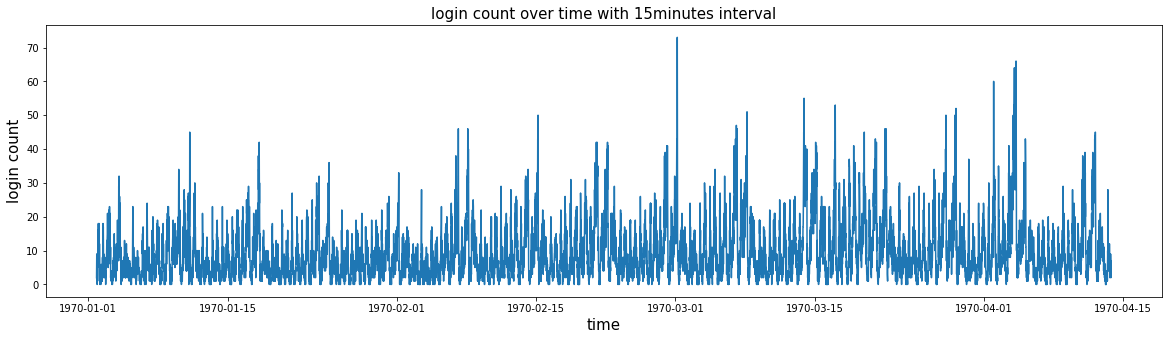

In [9]:
plt.figure(figsize=(20,5))
sns.lineplot(x=agg_15m.index, y='count', data=agg_15m)
plt.title('login count over time with 15minutes interval', fontsize=15)
plt.xlabel('time', fontsize=15)
plt.ylabel('login count', fontsize=15)
plt.show()

In [10]:
# summary statics
print(agg_15m['count'].describe())

count    9788.000000
mean        9.515938
std         8.328818
min         0.000000
25%         3.000000
50%         7.000000
75%        13.000000
max        73.000000
Name: count, dtype: float64


In [11]:
display(agg_15m[agg_15m['count'] == agg_15m['count'].min()])
display(agg_15m[agg_15m['count'] == agg_15m['count'].max()])

,count
login_time,
1970-01-01 21:30:00,0
1970-01-02 04:15:00,0
1970-01-02 06:15:00,0
1970-01-02 18:00:00,0
1970-01-03 08:45:00,0
...,...
1970-04-11 08:45:00,0
1970-04-13 05:30:00,0
1970-04-13 06:00:00,0


,count
login_time,
1970-03-01 04:30:00,73


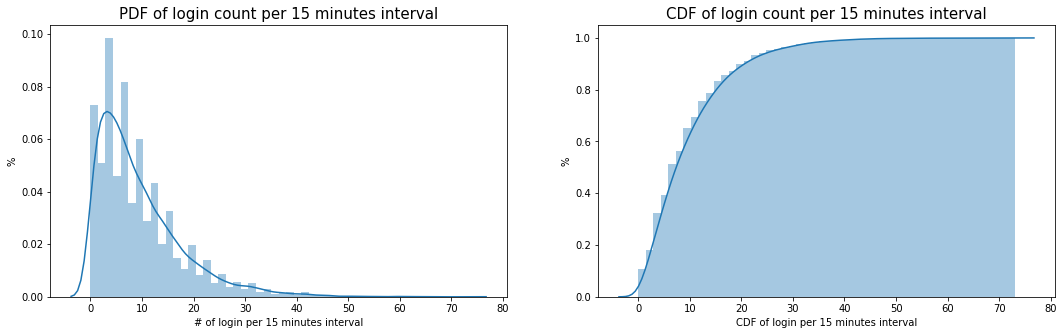

In [12]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

ax1 = sns.distplot(agg_15m['count'], ax=ax1)
ax1.set_title('PDF of login count per 15 minutes interval', fontsize=15)
ax1.set_xlabel('# of login per 15 minutes interval')
ax1.set_ylabel('%')
ax2 = sns.distplot(agg_15m['count'], kde_kws={'cumulative': True}, hist_kws={'cumulative': True})
ax2.set_title('CDF of login count per 15 minutes interval', fontsize=15)
ax2.set_xlabel('CDF of login per 15 minutes interval')
ax2.set_ylabel('%')
plt.show()

**Observation**:

- data provided are from Jan 1st to April 13 am 
- highest usage on March 1st, 1970 at 4:30 am
- total 9788 records
- see recurring spike over the time period
- appears to have a slight increasing trend 
- roughly 407 of 15 minutes intervals did not have use login
- The mode of login count is ~5-6
- Mean login count is about 10


**More time features**
<br>
It is not very easy to observe the recurring spike given the number of data point exist in one graph.
<br>
We will create some datetime features for easier grouping and visualization

In [13]:
#month
agg_15m['month'] = agg_15m.index.month
#week of the year
agg_15m['week'] = agg_15m.index.week
# actual date
agg_15m['date'] = agg_15m.index.date
# day of week
agg_15m['dayofweek'] = agg_15m.index.day_name()
# hour of the day
agg_15m['hour'] = agg_15m.index.hour
# time with 15 minutes interval
agg_15m['time'] = agg_15m.index.time
agg_15m.head()

,count,month,week,date,dayofweek,hour,time
login_time,,,,,,,
1970-01-01 20:00:00,2,1,1,1970-01-01,Thursday,20,20:00:00
1970-01-01 20:15:00,6,1,1,1970-01-01,Thursday,20,20:15:00
1970-01-01 20:30:00,9,1,1,1970-01-01,Thursday,20,20:30:00
1970-01-01 20:45:00,7,1,1,1970-01-01,Thursday,20,20:45:00
1970-01-01 21:00:00,1,1,1,1970-01-01,Thursday,21,21:00:00


#### 1 - Understanding login over time

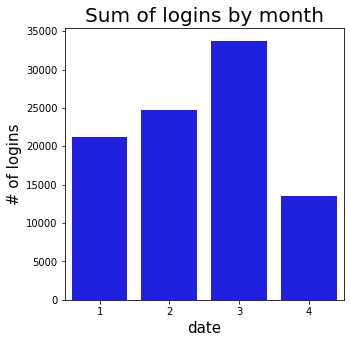

In [14]:
plt.figure(figsize=(5, 5))
sns.barplot(x='month', y='count', data=agg_15m, ci=None, estimator=sum, color='b')
plt.title('Sum of logins by month', fontsize=20)
plt.xlabel('date', fontsize=15)
plt.ylabel('# of logins', fontsize=15)
plt.show()

There is an increasing login from Jan through Mar. We don't have complete data for April to determine on the total usage in that month. We need to dig deeper into the weeks.

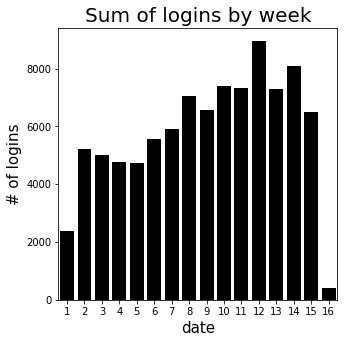

In [15]:
plt.figure(figsize=(5, 5))
sns.barplot(x='week', y='count', data=agg_15m, ci=None, estimator=sum, color='black' )
plt.title('Sum of logins by week', fontsize=20)
plt.xlabel('date', fontsize=15)
plt.ylabel('# of logins', fontsize=15)
plt.show()

Take out week 16, which was the week with incomplete data, we can say that overtime, the trend of login is increasing.

#### 2- Understanding daily login pattern

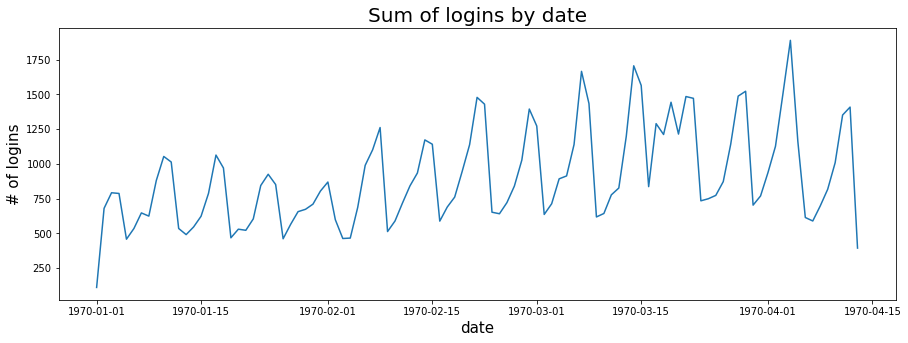

In [16]:
plt.figure(figsize=(15, 5))
sns.lineplot(x='date', y='count', data=agg_15m, ci=None, estimator=sum)
plt.title('Sum of logins by date', fontsize=20)
plt.xlabel('date', fontsize=15)
plt.ylabel('# of logins', fontsize=15)
plt.show()

Observe a recurring pattern on login, it is likely that the amount of usage vary by day of week.

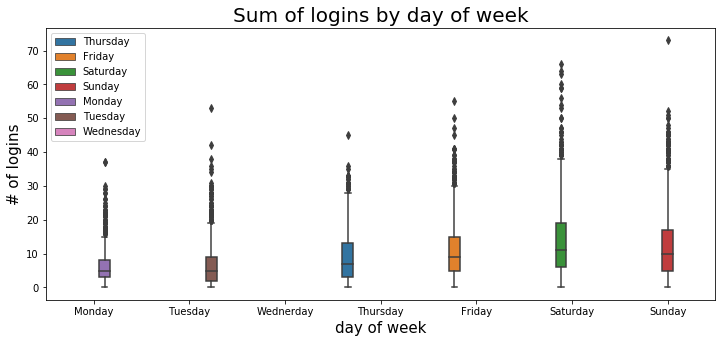

In [17]:
plt.figure(figsize=(12, 5))
sns.boxplot(x='dayofweek', y='count',
            order=['Monday', 'Tuesday', 'Wednerday',
                   'Thursday', 'Friday', 'Saturday',
                   'Sunday'], data=agg_15m, hue='dayofweek')
plt.title('Sum of logins by day of week', fontsize=20)
plt.xlabel('day of week', fontsize=15)
plt.ylabel('# of logins', fontsize=15)
plt.legend(loc='best')
plt.show()

Usage on Saturday appear to be highest on login. Monday has the lowest login

#### 3 - Understanding login by hour

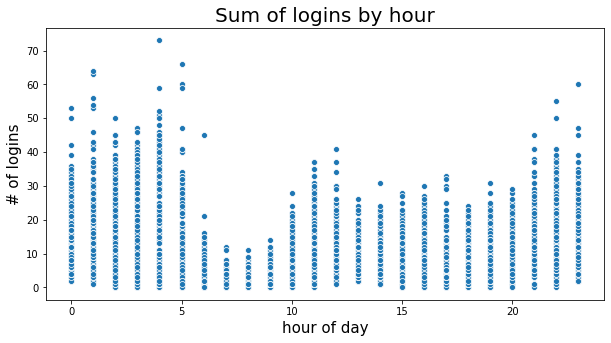

In [18]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='hour', y='count',
                data=agg_15m)
plt.title('Sum of logins by hour', fontsize=20)
plt.xlabel('hour of day', fontsize=15)
plt.ylabel('# of logins', fontsize=15)
plt.show()

Login tend to happen during mid-night to 5, could be related to night social events, in which people may use the service to take taxi.

Usage drops during the day, but start picking up after dinner time around 8 pm.

### Heatmap by hour by day

In [19]:
df_day_hour = pd.pivot_table(agg_15m, values='count', index='time', columns='dayofweek', aggfunc='sum')
df_day_hour = df_day_hour.reindex(columns=['Monday', 'Tuesday', 'Wednesday',
                   'Thursday', 'Friday', 'Saturday',
                   'Sunday'])

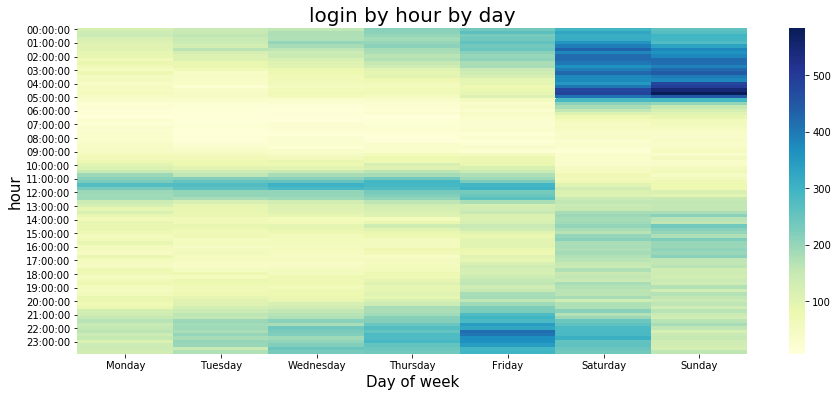

In [20]:
plt.figure(figsize=(15, 6))
sns.heatmap(df_day_hour, cmap="YlGnBu")
plt.title('login by hour by day', fontsize=20)
plt.xlabel('Day of week', fontsize=15)
plt.ylabel('hour', fontsize=15)
plt.show()

### In Summary

The login frequency are mostly high during weekend, starting Friday night till Saturday early morning before 5 am. The same peak appear on Saturday night and last till Sunday morning before 5 am.
<br>
The usage during weekdays are lower, though lunch hours appear to be a popular time for user to login Monday through Friday.
<br>
The login rate increase over time, and reach a peak on March 1st around 4-5 am. Perhaps there was a special overnight event happened on that day.